In [44]:
import torch
import torch.nn.functional as F
import gym 
from tqdm import tqdm 
import warnings

import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

Look at the Acrobot environment (2 joints swinging) 
https://github.com/openai/gym/blob/master/gym/envs/classic_control/acrobot.py 

* 3 Discrete actions:  The action is either applying +1, 0 or -1 torque on the joint between

* State has dimension 6: sin and cos of joints + angular velocity of joints 

In [3]:
env = gym.make('Acrobot-v1')
print('Action space: ', env.action_space) 
print('State space: ', env.observation_space)

Action space:  Discrete(3)
State space:  Box(6,)


TD(0) loss is delta 

In [4]:
class ValueMLP(torch.nn.Module):
    def __init__(self, input_size, l1_size, l2_size, 
                 lr, output_size=1): 
        super(ValueMLP, self).__init__()
        self.l1 = torch.nn.Linear(input_size, l1_size)
        self.l2 = torch.nn.Linear(l1_size, l2_size) 
        self.out = torch.nn.Linear(l2_size, output_size)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
    
    def forward(self, x): 
        l1 = torch.relu(self.l1(x))
        l2 = torch.relu(self.l2(l1))
        pred = self.out(l2) 
        return pred 
    

class TDAgent(): 
    def __init__(self, input_size, l1_size, l2_size, 
                 lr, gamma, 
                 iterations, max_steps_per_episode, env=env): 
        self.input_size = input_size
        self.l1_size = l1_size 
        self.l2_size = l2_size 
        self.lr = lr 
        self.gamma = gamma 
        self.iterations = iterations 
        self.max_steps_per_episode = max_steps_per_episode
        self.cuda0 = torch.device('cuda:0')
        self.mlp = ValueMLP(self.input_size, 
                            self.l1_size, self.l2_size, self.lr) 
        
    
    def cuda_tensor(self, val): 
        return torch.tensor(val, dtype=torch.float32, device=self.cuda0)
    
    def train(self):
        self.mlp.cuda() 
              
        losses = [] 
        for i in range(self.iterations): 
            observation = env.reset() 
            episode_loss = 0 
            
            for j in range(self.max_steps_per_episode): 
                # zero out gradients
                self.mlp.optimizer.zero_grad() 
                episode_loss = 0 
                
                action = env.action_space.sample()
                new_obs, reward, done, info = env.step(action)
                
                # Convert floats to tensor 
                observation = self.cuda_tensor(observation) 
                new_obs = self.cuda_tensor(new_obs)
                reward = self.cuda_tensor(reward)
                
                # predict values 
                value_obs = self.mlp(observation) 
                value_new_obs = self.mlp(new_obs) 
                
                # square delta for MSE 
                delta = (reward + self.gamma * value_new_obs * (1-done) - value_obs) ** 2
                episode_loss += delta 
                observation = new_obs 
                
                delta.backward() 
                self.mlp.optimizer.step() 
                
                if done: 
                    losses.append(episode_loss.item()) 
                    if i % 10 == 0: 
                        print(f'Episode {i} Total steps: {j} Loss: {episode_loss.item()}')
                    break
        return losses 
            
        
        
        

In [5]:
input_size = 6
l1_size = 1024 
l2_size = 512 
lr = 1e-5 
gamma = 0.99 
iterations = 1000 
max_steps_per_episode = 2000 

In [70]:
agent = TDAgent(input_size, l1_size, l2_size, lr, gamma, 
                iterations, max_steps_per_episode)
print(agent.mlp) 
losses = agent.train() 

ValueMLP(
  (l1): Linear(in_features=6, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)
Episode 0 Total steps: 499 Loss: -1.039920449256897
Episode 10 Total steps: 499 Loss: -2.198887825012207
Episode 20 Total steps: 499 Loss: -4.031208515167236
Episode 30 Total steps: 499 Loss: -5.064327239990234
Episode 40 Total steps: 499 Loss: -9.616744995117188
Episode 50 Total steps: 499 Loss: -15.986920356750488
Episode 60 Total steps: 499 Loss: -18.8606014251709
Episode 70 Total steps: 499 Loss: -22.787410736083984
Episode 80 Total steps: 499 Loss: -22.020475387573242
Episode 90 Total steps: 499 Loss: -24.691686630249023
Episode 100 Total steps: 499 Loss: -27.42555046081543
Episode 110 Total steps: 499 Loss: -32.116607666015625
Episode 120 Total steps: 499 Loss: -75.19561004638672
Episode 130 Total steps: 499 Loss: -70.4946517944336
Episode 140 Total steps: 499 Loss: -53.29037094116211
Epis

Text(0, 0.5, 'Loss')

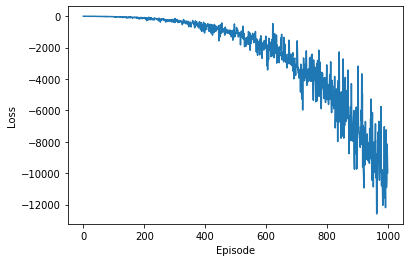

In [73]:
plt.plot(losses)
plt.xlabel('Episode')
plt.ylabel('Loss')

### Actor Critic 

In [74]:
class ActorMLP(ValueMLP): 
    def __init__(self, **kwargs):
        super().__init__(**kwargs) 
        
    def forward(self, x): 
        l1 = torch.relu(self.l1(x))
        l2 = torch.relu(self.l2(l1))
        logits = self.out(l2) 
        pred = F.softmax(logits)
        return pred 
        

class ActorCriticAgent(TDAgent):
    def __init__(self, num_actions, actor_lr, critic_lr, **kwargs): 
        super().__init__(lr=actor_lr, **kwargs)
        self.num_actions = num_actions 
        self.actor_lr = actor_lr 
        self.critic_lr = critic_lr 
        self.actor = ActorMLP(input_size=self.input_size, 
                         l1_size=self.l1_size, l2_size=self.l2_size, 
                         output_size=self.num_actions, lr=self.actor_lr)
        self.critic = ValueMLP(input_size=self.input_size, 
                          l1_size=self.l1_size, l2_size=self.l2_size, 
                          output_size=1, lr=self.critic_lr)
        self.actor.cuda() 
        self.critic.cuda() 
        
        self.episode_losses = [] 
        print(self.actor) 
        print(self.critic)
        
    def sample_action(self, pred): 
        """Return an action as a int value, log_prob as a tensor"""
        dist = torch.distributions.Categorical(probs=pred)
        action = dist.sample() 
        log_prob = dist.log_prob(action) 
        return action.item(), log_prob 
    
    def train(self): 
        # Loop over episodes 
        for i in range(self.iterations):
            # Reset environment and get starting state 
            observation = env.reset() 
            # Cast observation to a cuda tensor 
            observation = self.cuda_tensor(observation) 
            
            for j in range(self.max_steps_per_episode): 
                action_pred = self.actor(observation)

                # Sample an action 
                action, log_prob = self.sample_action(action_pred.data)  

                # Take a step 
                new_obs, reward, done, info = env.step(action) 
                new_obs = self.cuda_tensor(new_obs) 
                reward = self.cuda_tensor(reward) 
    
                # Use critic to estimate value
                value_obs = self.critic(observation)
                value_new_obs = self.critic(new_obs) 

                # Critic loss is TD loss 
                delta = reward - self.gamma * value_new_obs * (1-done) - value_obs 

                actor_loss = -log_prob * delta 
                critic_loss = delta ** 2 
                # try to keep both losses negative so they don't cancel out? 
                loss = torch.abs(actor_loss) * -1 + critic_loss * -1 
                
                # Take gradients and update
                loss.backward()  
                self.actor.optimizer.step() 
                self.critic.optimizer.step() 
                
                # Update new observation to be current observation 
                observation = new_obs 
                
                # Print out loss info every 10 episodes 
                if done: 
                    self.episode_losses.append(loss.item())
                    if i % 50 == 0: 
                        print(f'Episode {i} Steps: {j} Loss: {loss.item()}')
                    break
                


In [75]:
ac_agent = ActorCriticAgent(num_actions=3, input_size=input_size, 
                            l1_size=l1_size, l2_size=l2_size, 
                            actor_lr=lr, critic_lr=lr,
                            gamma=gamma, iterations=2500, 
                            max_steps_per_episode=max_steps_per_episode) 

ac_losses = ac_agent.train()

ActorMLP(
  (l1): Linear(in_features=6, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=3, bias=True)
)
ValueMLP(
  (l1): Linear(in_features=6, out_features=1024, bias=True)
  (l2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=1, bias=True)
)
Episode 0 Steps: 499 Loss: -518.16015625
Episode 50 Steps: 499 Loss: -2183273216.0
Episode 100 Steps: 499 Loss: -38856282112.0
Episode 150 Steps: 499 Loss: -154144096256.0
Episode 200 Steps: 499 Loss: -656478437376.0
Episode 250 Steps: 499 Loss: -1382188974080.0
Episode 300 Steps: 499 Loss: -11583826690048.0
Episode 350 Steps: 499 Loss: -6209440055296.0
Episode 400 Steps: 499 Loss: -49634013609984.0
Episode 450 Steps: 499 Loss: -110419523928064.0
Episode 500 Steps: 499 Loss: -216729770786816.0
Episode 550 Steps: 499 Loss: -179777214349312.0
Episode 600 Steps: 499 Loss: -224709836800000.0
Episode 650 Steps

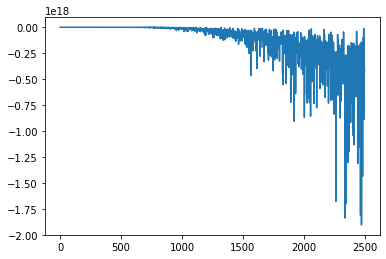

In [76]:
plt.plot(ac_agent.episode_losses)

In [86]:
import time 

obs = env.reset() 
actor_agent = ac_agent.actor.eval() 

for _ in range(500): 
    obs = ac_agent.cuda_tensor(obs)
    action_dist = ac_agent.actor(obs) 
    action, _ = ac_agent.sample_action(action_dist) 
    
    obs, reward, done, info = env.step(action)
    env.render() 
    env.step(action) 
    
    if done: 
        break 
    time.sleep(0.05)
    
env.close() 